# Logestic Regression with Numpy

jhbale11

[Coursera]Andrew Ng 's Deep Learning Lecture

https://github.com/suqi/deeplearning_andrewng

앤드류 응 교수님의 딥러닝 강의를 듣고 예제를 제 방식대로 연습한 결과입니다.

## Import Package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils_123 import load_dataset

## Problem Statement
- training set은 고양이인 경우 y=1, 고양이가 아닌 경우 y=0으로 라벨되어 있습니다.
- 테스트셋 역시 고양이인지 여부가 라벨되어 있습니다
- 각각의 이미지는 (pixel의 수, pixel의 수, 3)의 shape을 가지며 3은 RGB 세개의 채널을 의미합니다. 따라서 각각의 이미지는 높이와 너비의 곱으로 표현될 수 있습니다.

## Load Dataset

In [2]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
train_set_x_orig.shape, train_set_y.shape, test_set_x_orig.shape, test_set_y.shape

((209, 64, 64, 3), (1, 209), (50, 64, 64, 3), (1, 50))

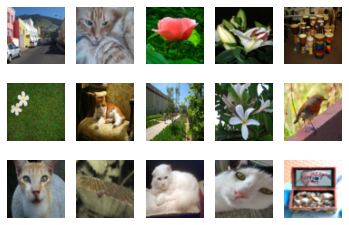

In [3]:
for i in range(1, 16):
    plt.subplot(3,5,i)
    plt.imshow(train_set_x_orig[i])
    plt.axis('off')
plt.show()

이미지 당 (samples, 64, 64, 3) 크기의 배열인 것을 (64*64*3, samples) 크기로 만들어준다.

각각의 이미지의 Shape은 (높이, 너비, RGB)의 Shape로 (64, 64, 3)입니다.

우리의 Training Dataset은 Numpy array 로 각각의 Column이 Flattened Image를 나타내는 형태인 바, 각각의 Training set을 Flatten 하여야 합니다.

즉 (64,64,3)의 Shape를 (64*64*3, 1)의 Single Vector로 변환하여야 합니다.

In [4]:
train_set_x_flatten = train_set_x_orig.reshape(-1, 64*64*3).T
test_set_x_flatten = test_set_x_orig.reshape(-1, 64*64*3).T
train_set_x_flatten.shape

(12288, 209)

In [5]:
# 각 픽셀은 0~255 사이의 값을 가진다. 255으로 나누어 정규화해준다.
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

**기억해야 할 것!**

- 해결하려고 하는 문제의 Dimensions, Shapes를 알아야 합니다.
- Dataset을 일차원 Vector의 형태로 Reshape하여야 합니다.
- 정규화를 거쳐야 합니다.

In [6]:
# 훈련셋 내 고양이의 비율은 72%이다.
print(np.sum(train_set_y) / len(train_set_y))

# 테스트셋 내 고양이의 비율은 33%이다.
print(np.sum(test_set_y) / len(test_set_y))

72.0
33.0


# Number Image Data Load & Preprocessing

In [7]:
from sklearn.datasets import load_digits
data = load_digits()
data_x, data_y = data['images'], data['target']

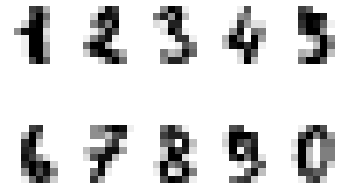

In [8]:
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(data_x[i], cmap='binary')
    plt.axis('off')
plt.show()

데이터가 1부터 0까지 순서대로 있으므로 섞어줍니다.

In [9]:
index = np.random.permutation(data_x.shape[0])
data_x_shuffled = data_x[index]
data_y_shuffled = data_y[index]

Size를 맞춰줍니다. 

또한 여기서는 짝수와 홀수를 분류하는 문제로 바꿔서 연습할 것입니다.

In [10]:
data_x_flattend = data_x_shuffled.reshape(-1,8*8).T / 16
data_y_flattend = data_y_shuffled.reshape(1,-1)
data_y_flattend_binary = np.where(data_y_flattend%2==0,0,1)

## Train Test Split

In [11]:
test_size = round(data_x_flattend.shape[1] * 0.2)

X_train = data_x_flattend[:, test_size:] 
X_test = data_x_flattend[:, :test_size] 
y_train = data_y_flattend_binary[:,test_size:]
y_test = data_y_flattend_binary[:,:test_size]

In [12]:
X_train.shape, y_train.shape, y_train.shape, y_test.shape

((64, 1438), (1, 1438), (1, 1438), (1, 359))

# Logestic Regression Model with Numpy

이제부터 Numpy를 사용하여 Logestic Regression Model을 만들어 보겠습니다.

1) 2차원 이미지를 1차원 벡터로 Flatten합니다.
2) 각각의 원소를 255로 나누어 정규화합니다. 이때 정규화한 값이 Input이 됩니다.
3) Wx+b의 Input을 Loss Function을 거쳐 고양이인지 판별할 확률을 구합니다.
4) Output이 0.5보다 크면 고양이라고 판별하며, 그렇지 않으면 아니라고 판별합니다.

**Key Steps!**
- Initialize the parameters of the model
- Learn the parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

$z^{(i)} = w^T x^{(i)} + b \tag{1} ... (1) $

$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2} ... (2) $

$\mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3} ... (3) $

In [13]:
# 시그모이드 함수
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))    
    return s

# 가중치 초기화
def initialize_params(dim):
    w = np.zeros((dim, 1))
    b = 0
    return w, b

# 손실함수 및 그래디언트 계산
def propagate(w, b, X, Y, X_val, Y_val):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    sample_size = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b) # (1, sample size)
    cost = -np.sum(Y * np.log(A) + (1-Y) * np.log(1-A)) / sample_size 
    dw = np.dot(X, (A - Y).T) / sample_size # (feature size, sample size) dot (sample size, 1)
    db = np.sum(A - Y) / sample_size
    grads = {'dw':dw,
             'db':db}
    
    # 테스트 셋에 대해 손실값을 계산한다.
    A_val = sigmoid(np.dot(w.T, X_val) + b)
    val_cost = -np.sum(Y_val * np.log(A_val) + (1-Y_val) * np.log(1-A_val)) / sample_size 
    
    costs = {'cost':cost, 'val_cost':val_cost}

    return grads, costs

# 최적화
def optimize(w, b, X, Y, X_val, Y_val, num_iterations, learning_rate):
    cost = []
    val_cost = []
    for i in range(num_iterations):
        grads, costs = propagate(w, b, X, Y, X_val, Y_val)
        dw = grads['dw']
        db = grads['db']
        w -= learning_rate*dw
        b -= learning_rate*db
        
        cost.append(costs['cost'])
        val_cost.append(costs['val_cost'])
        
    params = {'w':w,
              'b':b}
    costs = {'costs':cost, 'val_costs':val_cost}
    return params, costs


# 훈련된 가중치로 클래스를 예측하는 함수
def predict(w, b, X):
    A = sigmoid(np.dot(w.T, X) + b)
    Y_prediction = np.where(A > 0.5, 1, 0)
    return Y_prediction

# 위 함수들을 하나로 묶어서 모델을 만든다.
def model(X_train, Y_train, X_test, Y_test, num_iterations = 200, learning_rate = 0.05):
    
    w, b = initialize_params(X_train.shape[0])
    params, costs = optimize(w, b, X_train, Y_train, X_test, Y_test, num_iterations, learning_rate)

    w = params["w"]
    b = params["b"]
    
    # 훈련셋과 테스트셋에 대한 최종 예측 수행
    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b , X_test)
    
    # 정확도 계산
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs['costs'],
         "val_costs":costs['val_costs'],
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b}
    
    return d

# 고양이 데이터에 모델 적용해보기

In [14]:
cats_d = model(train_set_x, train_set_y, test_set_x, test_set_y, 2000, 0.005)

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


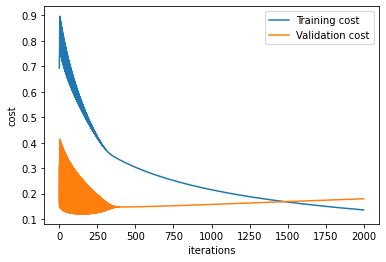

In [15]:
# 손실값 그리기
costs = cats_d['costs']
val_costs = cats_d['val_costs']
plt.plot(costs, label='Training cost')
plt.plot(val_costs, label='Validation cost')
plt.legend()
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show() # 과적합이 일어났다.

## Hyperparameter Tuning

- Learning Rate 조절

In [16]:
cats_d = model(train_set_x, train_set_y, test_set_x, test_set_y, 2000, 0.01)

train accuracy: 99.52153110047847 %
test accuracy: 70.0 %


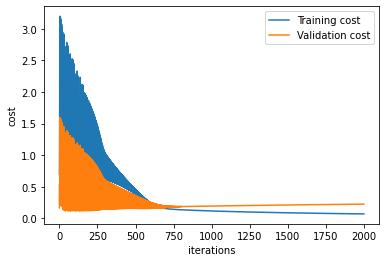

In [17]:
# 손실값 그리기
costs = cats_d['costs']
val_costs = cats_d['val_costs']
plt.plot(costs, label='Training cost')
plt.plot(val_costs, label='Validation cost')
plt.legend()
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show() # learning rate을 크게 하니, 학습 과정에서 진폭이 커졌다.

다음은 학습률에 따른 훈련 진행 과정을 보여줍니다.

Images courtesy of Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">

# 숫자 이미지 데이터에 모델 적용해보기

In [18]:
d = model(X_train, y_train, X_test, y_test, 4000, 1) # 간단한 모델인데, 성능이 꽤 좋다. 

train accuracy: 93.3240611961057 %
test accuracy: 91.36490250696379 %


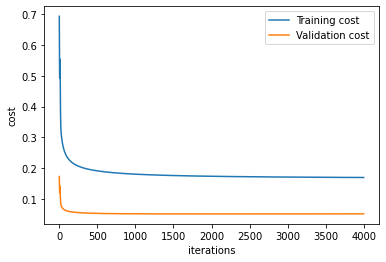

In [19]:
# 손실값 그리기
costs = d['costs']
val_costs = d['val_costs']
plt.plot(costs, label='Training cost')
plt.plot(val_costs, label='Validation cost')
plt.legend()
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show() # 데이터에 따라 학습률을 다르게 하는 것이 좋음을 알 수 있다.

홀짝 예측: [1]
실제 레이블: [8]


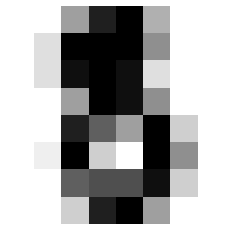

In [20]:
index = 10
print('홀짝 예측:', predict(d['w'], d['b'], X_test[:,index]))
print('실제 레이블:', data_y_flattend[:,index])
plt.imshow(X_test[:,index].reshape(8,8), cmap='binary')
plt.axis('off')
plt.show() #

# with Sklearn
위에서는 연습 삼아 로지스틱 회귀를 넘파이로 직접 구현했습니다. 

Hidden States가 없는 위와 같은 Logestic 분류기는 sklearn을 이용해 간단히 만들 수 있습니다.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
log_reg = LogisticRegression(solver='lbfgs', max_iter=2000)

# 고양이 분류 문제에 적용
log_reg.fit(train_set_x.T, train_set_y.ravel())
accuracy_score(test_set_y.T, log_reg.predict(test_set_x.T))

0.72

In [22]:
# 숫자 분류 문제에 적용
log_reg.fit(X_train.T, y_train.ravel())
accuracy_score(y_test.T, log_reg.predict(X_test.T)) # 직접 만든 회귀와 비슷한 결과가 나왔다.

0.9108635097493036